<a href="https://colab.research.google.com/github/Arghatak/MIT-ADSP-Projects/blob/main/AditiRoyGhatak_Capstone_CNN_MalariaDetection_04212022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Problem* Definition
    
### The context:

Malaria is deried from an italian word “Mal’ aria” meaning "Bad air". It is a contagious disease caused by Plasmodium parasites that are transmitted to humans through the bites of infected female Anopheles mosquitoes. The parasites enter the blood and begin damaging red blood cells (RBCs) that carry oxygen, which can result in respiratory distress and other complications (Fever, Chills, Sweats, Headaches, Nausea and vomiting, body aches, and general malaise). The lethal parasites can stay alive for more than a year in a person’s body without showing any symptoms. Therefore, late treatment can cause complications and could even be fatal. **Almost 50% of the world’s population is in danger from malaria**. There were more than 229 million malaria cases and 400,000 malaria-related deaths reported over the world in 2019. Children under 5 years of age are the most vulnerable population group affected by malaria; in 2019 they accounted for 67% of all malaria deaths worldwide. 

The various ways malaria is diagnosed are:
- Thick and thin blood smears: Two smears are prepared on glass slides and staining is used to enhance visualization of the cell or specific cellular components under a microscope.
Traditional diagnosis of malaria in the laboratory requires careful inspection by an experienced professional to discriminate between healthy and infected red blood cells. It is a **tedious, time-consuming process, and the diagnostic accuracy (which heavily depends on human expertise) can be adversely impacted by inter-observer variability**. 
- Rapid Diagnostic Test (Antigen testing) - RDT is used when microscopy is not avaiable. This is also called the dipstick test because a few drop of blood is applied on a test strip to detect malaria antigens.
- Molecular Tests (Polymerase Chain Reaction, PCR) - This laboratory test amplifies parasite DNA and detects plasmodium specied causing infection.
- Antibody Testing (serology) - Antibodies are detected in the patients blood

Microscopic blood smear images imaging is essential to cellular analysis as the morphology and texture characteristics of erythrocyte cells changes during malaria infection and progression. 

Without staining, however, red blood cells and parasites have close transparency, resulting in low contrast. (SOURCE: https://arxiv.org/ftp/arxiv/papers/1909/1909.02829.pdf)

An automated system can help with the **early and accurate detection** of malaria. Applications of **automated classification techniques using Machine Learning (ML) and Artificial Intelligence (AI)** have consistently shown higher accuracy than manual classification. It would therefore be highly beneficial to propose a method that performs malaria detection using Deep Learning Algorithms.


### The objectives:

- Enhance the low-resolution image and restore high-resolution image correctly by inferring high-frequency components of a low-resolution image
- Reduce misdiagnosis and enable rapid and accurate diagnosis so the disease can be contained and the infection does not spread
- Build an efficient computer vision model to detect malaria
- Identify whether the image of a red blood cell is that of one infected with malaria (classify as parasitized or uninfected)

### Problem formulation:

- Importing Libraries.
- Loading the data.
- Image preprocessing.
- Plotting images and its labels to understand how does an infected cell and uninfected cell looks like.
- Pass labelled images through a CNN to build a classifier 
  - Test different activation functions
  - Test hyperparameter tuning
  - Test Mask R-CNN
  - Test pre-trained models (VGG19, VGG16, Resnet, Imagenet etc)
- Test the classifier accuracy on test images
- Compate different models and propose a solution design that best fits the project objectives

### Data Description
There are a total of 24,958 train and 2,600 test images (RGB format) that we have taken from microscopic images. These images are of the following categories:

- Parasitized: The parasitized cells contain the Plasmodium parasite which causes malaria
- Uninfected: The uninfected cells are free of the Plasmodium parasites

###<b> Mounting the Drive

In [13]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.1 s (started: 2022-04-22 03:43:57 +00:00)


In [14]:
!nvidia-smi

Fri Apr 22 03:43:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import sys
print(sys.version)
!python --version

3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
Python 3.7.13
time: 118 ms (started: 2022-04-22 03:43:59 +00:00)


###<b>Loading libraries</b>

In [17]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

from random import shuffle

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

2.8.0
time: 13.5 ms (started: 2022-04-22 03:44:03 +00:00)


In [18]:
import sklearn
sklearn.__version__

'1.0.2'

time: 5.01 ms (started: 2022-04-22 03:44:03 +00:00)


In [19]:
#Clearing backend
backend.clear_session()

#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

time: 32.7 ms (started: 2022-04-22 03:44:03 +00:00)


### <b>Let us load the data</b>

In [20]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

time: 9.58 s (started: 2022-04-22 03:44:03 +00:00)


The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

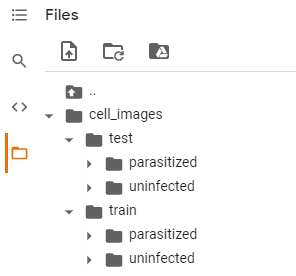

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [21]:
#Storing the path of the extracted "train" folder 
train_dir = 'cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

time: 3.4 ms (started: 2022-04-22 03:44:13 +00:00)


In [22]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

time: 33 s (started: 2022-04-22 03:44:13 +00:00)


In [23]:
#Storing the path of the extracted "test" folder 
test_dir = 'cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

time: 3.07 ms (started: 2022-04-22 03:44:47 +00:00)


In [24]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

time: 2.99 s (started: 2022-04-22 03:44:47 +00:00)


###<b>Normalize the images

In [25]:
# try to use value_counts to count the values
df_train = pd.DataFrame(data=train_labels,columns=['Classcount'])
df_test = pd.DataFrame(data=test_labels,columns=['Classcount'])
print(df_train.value_counts())
print(df_test.value_counts())

Classcount
1             12582
0             12376
dtype: int64
Classcount
0             1300
1             1300
dtype: int64
time: 25.2 ms (started: 2022-04-22 03:44:50 +00:00)


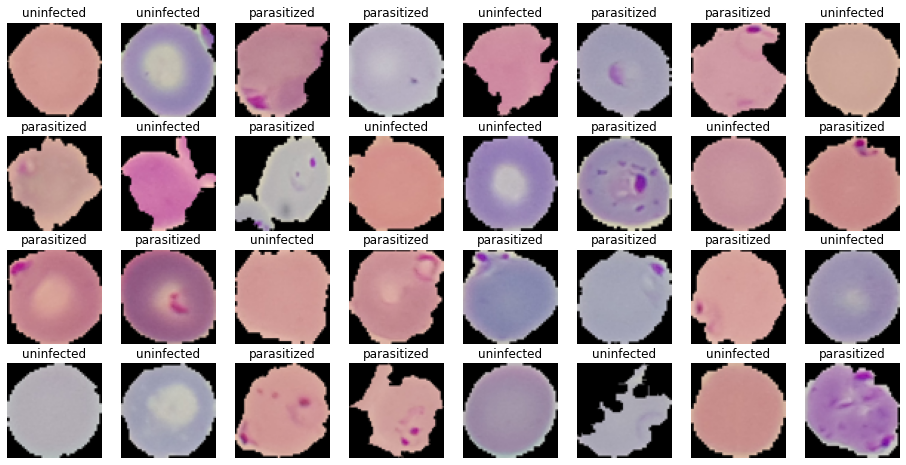

time: 3.02 s (started: 2022-04-22 03:44:50 +00:00)


In [26]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)
plt.figure(1 , figsize = (16 , 8))

for n in range(1, 33):
    plt.subplot(4, 8, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

In [27]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

# try to use min and max function from numpy
print('Train', train_images.min(), train_images.max()) 
print('Test', test_images.min(), test_images.max())

Train 0.0 1.0
Test 0.0 1.0
time: 2.19 s (started: 2022-04-22 03:44:53 +00:00)


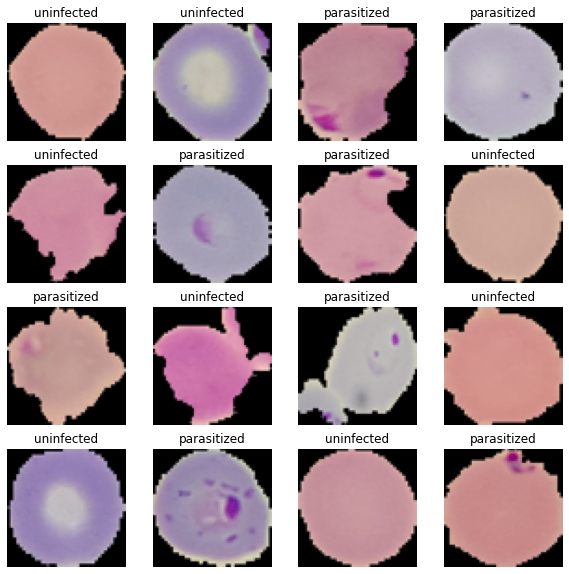

time: 1.02 s (started: 2022-04-22 03:44:57 +00:00)


In [28]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)
plt.figure(1 , figsize = (10 , 10))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

## Observations and insights:

### Observations:

- There are ~25k training anf ~2600 testing images in the dataset
- Each of the above sets are nearly equally split into Parasitized and Uninfected images
- The images are in RGB format
- The images were downloaded, and normalized to make all images the same size (64 pixels in height and width)
- The above specification can be changed to 224 pixels if there is enough memory for computation

### Insights:

- Here the data is stored in a 4-dimensional NumPy array. 
  - The first dimension 24958 is denoting the number of images in the training data. Each image is stacked on top of the other as a 3-dimensional NumPy array. 
  - The second dimension 64 is denoting the number of pixels along the x-axis
  - The third dimension 64 is denoting the number of pixels along the y-axis 
  - The fourth dimension 3 is the total number of channels in those images i.e. these are colored images consisting of RGB (Red, Green, and Blue) channels.
- In the 3-dimensional NumPy representation of the first image in the training data, each pixel in an image has 3 values - the intensity of R, G, and B channels, and the size of each image is 64x64. So, each image is represented by 64 arrays of shape 64x3.
- The data is equally split into classes and that should help with a more balanced learning model
- We will explore HSV format to make sure we remove issues with saturation and test the model for better results

As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

## Image Preprocessing

In [29]:
# function to find the mean
def find_mean_img(full_mat, title):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)[0]
    # reshape it back to a matrix
    plt.imshow(mean_img)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

def find_median_img(full_mat, title):
    # calculate the average
    median_img = np.median(full_mat, axis = 0)[0]
    # reshape it back to a matrix
    plt.imshow(median_img)
    plt.title(f'Median {title}')
    plt.axis('off')
    plt.show()
    return median_img

time: 9.46 ms (started: 2022-04-22 03:44:58 +00:00)


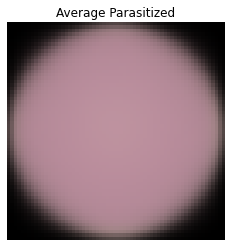

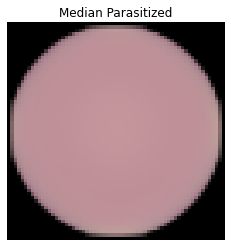

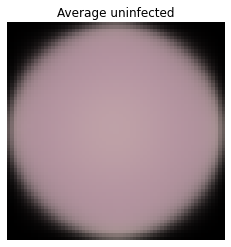

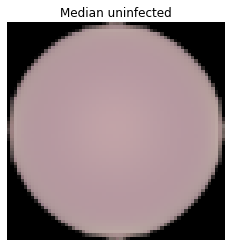

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


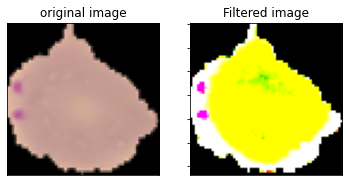

time: 14.9 s (started: 2022-04-22 03:44:58 +00:00)


In [30]:
# If the label=1 then the image is parasitised and if the label=0 then the image is uninfected
parasitized_data=[]                # Create a list to store the parasitized data
uninfected_data=[]                # Create a list to store the uninfected data               
for img, label in zip(train_images, train_labels):
        if label==1:
              parasitized_data.append([img]) 
        else:
          uninfected_data.append([img])         
#compute the mean and median
parasitized_mean = find_mean_img(np.array(parasitized_data), 'Parasitized')   # find the mean
parasitized_median = find_median_img(np.array(parasitized_data), 'Parasitized')   # find the median
uninfected_mean = find_mean_img(np.array(uninfected_data), 'uninfected')   # find the mean
uninfected_median = find_median_img(np.array(uninfected_data), 'uninfected')   # find the median

#display the original train image alongside the filtered image
plt.figure()
#Original image
plt.subplot(1,2,1)
plt.imshow(train_images[20])

plt.tick_params(axis='both',which='both',
                    top=False,bottom=False,left=False,right=False,labelbottom=False,
                    labeltop=False,labelleft=False,labelright=False)
plt.title('original image')
#filtered image
plt.subplot(1,2,2)
plt.imshow(30*(train_images[20]-parasitized_mean))

plt.tick_params(axis='both',which='both',
                    top=False,bottom=False,right=False,labelbottom=False,
                    labeltop=False,labelleft=False,labelright=False)
plt.title('Filtered image')
plt.show()

In [31]:
print(parasitized_mean.mean())
print(np.median(parasitized_mean))
print(uninfected_mean.mean())
print(np.median(uninfected_mean))

0.46150437
0.5461786
0.4817944
0.58357656
time: 3.78 ms (started: 2022-04-22 03:45:12 +00:00)


### Converting RGB to HSV of Images using OpenCV

#### Converting Train Data

In [32]:
import cv2
gfx=[]   # to hold the HSV image array
for i in np.arange(0,100,1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2HSV)
  gfx.append(a)
gfx=np.array(gfx)

time: 336 ms (started: 2022-04-22 03:45:12 +00:00)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


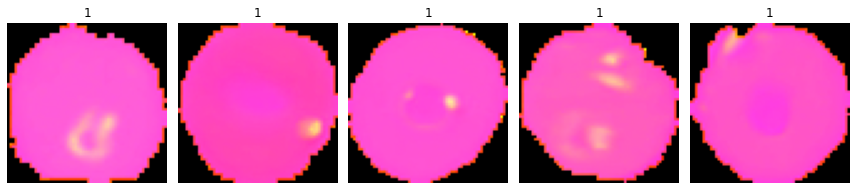

time: 616 ms (started: 2022-04-22 03:45:13 +00:00)


In [33]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(12,12))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

#### Converting Test Data

In [34]:
# Similarly you can visualize for the images in the test data
gfxtest=[]
for i in np.arange(0,100,1):
  a=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2HSV)
  gfxtest.append(a)
gfxtest=np.array(gfxtest)

time: 8.49 ms (started: 2022-04-22 03:45:14 +00:00)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


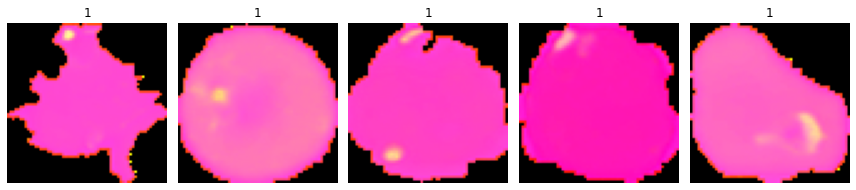

time: 569 ms (started: 2022-04-22 03:45:14 +00:00)


In [35]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(12,12))
for t,i in zip(range(5),viewimage):
  Title=test_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfxtest[i])
  ax[t].set_axis_off()
  fig.tight_layout()

### Observations and insights:
- HSV (hue, saturation, value) or HSB (hue, saturation, brightness) are alternative representations of the RGB color model, designed in the 1970s by computer graphics researchers to more closely align with the way human vision perceives color-making attributes
- HSV separates color components from intensity and that makes it very useful in Computer Vision applications
- In the HSV (or HSL) color-space, color is divided into 3 components:
  - Hue, an angle from 0 to 359 degrees.
  - Saturation, or the complexity of the wavelengths being seen.
  - Value, or the brightness of the light.

source: https://www.reddit.com/r/MLQuestions/comments/6ueiis/hsv_vs_rgb_grayscale_for_convolutional_neural/

##<B>One Hot Encoding on the train and test labels

In [36]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

time: 2.63 ms (started: 2022-04-22 03:45:14 +00:00)


In [37]:
train_labels.shape

(24958, 2)

time: 7.58 ms (started: 2022-04-22 03:45:14 +00:00)


### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

####<b> Importing the required libraries

In [38]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

time: 13.5 ms (started: 2022-04-22 03:45:14 +00:00)


####<b> Building the model

In [39]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512,activation="relu"))
#model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

####<b> Compiling the model

In [40]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 15.4 ms (started: 2022-04-22 03:45:23 +00:00)


In [41]:
model.save('model.h5')

time: 44.9 ms (started: 2022-04-22 03:45:23 +00:00)


<b> Using Callbacks 

In [42]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

time: 1.97 ms (started: 2022-04-22 03:45:23 +00:00)


<b> Fit and train our Model

In [43]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history=model.fit(train_images,train_labels,batch_size=32, validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 21s 11ms/step - loss: 0.4265 - accuracy: 0.7933 - val_loss: 0.2178 - val_accuracy: 0.9048
Epoch 2/20
624/624 [==============================] - 6s 10ms/step - loss: 0.1304 - accuracy: 0.9517 - val_loss: 0.2198 - val_accuracy: 0.9367
Epoch 3/20
624/624 [==============================] - 9s 14ms/step - loss: 0.0987 - accuracy: 0.9694 - val_loss: 0.0962 - val_accuracy: 0.9884
Epoch 4/20
624/624 [==============================] - 7s 12ms/step - loss: 0.0814 - accuracy: 0.9739 - val_loss: 0.0833 - val_accuracy: 0.9856
Epoch 5/20
624/624 [==============================] - 7s 12ms/step - loss: 0.0732 - accuracy: 0.9757 - val_loss: 0.0556 - val_accuracy: 0.9906
Epoch 6/20
624/624 [==============================] - 8s 14ms/step - loss: 0.0693 - accuracy: 0.9776 - val_loss: 0.0803 - val_accuracy: 0.9858
Epoch 7/20
624/624 [==============================] - 6s 10ms/step - loss: 0.0669 - accuracy: 0.9765 - val_loss: 0.1021 - val_accuracy: 0.975

####<b> Evaluating the model on test data

In [44]:
test_acc = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', test_acc[1])
train_acc = model.evaluate(train_images, train_labels, verbose=1)
print('\n', 'Train_Accuracy:-', train_acc[1])

82/82 [==============================] - 1s 9ms/step - loss: 0.0621 - accuracy: 0.9854

 Test_Accuracy:- 0.9853846430778503
780/780 [==============================] - 6s 8ms/step - loss: 0.0498 - accuracy: 0.9859

 Train_Accuracy:- 0.9859363436698914
time: 8.47 s (started: 2022-04-22 03:48:03 +00:00)


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



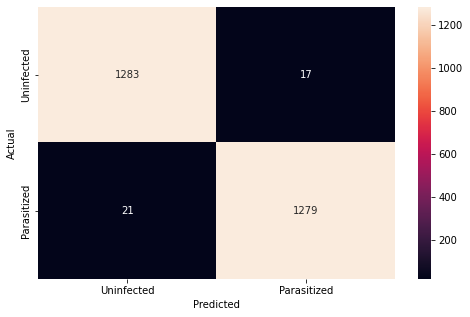

time: 906 ms (started: 2022-04-22 03:48:12 +00:00)


In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [46]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

time: 6.05 ms (started: 2022-04-22 03:48:13 +00:00)


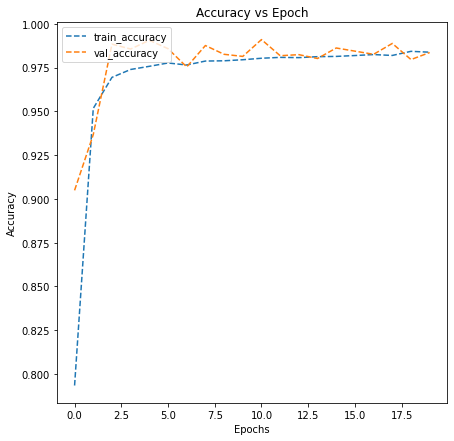

time: 253 ms (started: 2022-04-22 03:48:13 +00:00)


In [47]:
plot_accuracy(history)



* Here we can clearly observe that the training and valiation accuracy are increasing 
* Validation accuracy trends close to train accuracy and there is no evidence of overfitting

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1 - Base Model with more layers
####<b> Trying to improve the performance of our model by adding new layers


In [48]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

time: 14.4 ms (started: 2022-04-22 03:48:13 +00:00)


####<b> Building the Model

In [49]:
#creating sequential model
model1=Sequential()

# Build the model here
model1.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(500,activation="relu"))
model1.add(Dense(256,activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(128,activation="relu"))
model1.add(Dense(64,activation="relu"))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

####<b> Compiling the model

In [50]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 9.83 ms (started: 2022-04-22 03:48:17 +00:00)


In [51]:
model1.save('model1.h5')

time: 63.8 ms (started: 2022-04-22 03:48:17 +00:00)


<b> Using Callbacks

In [52]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

time: 1.74 ms (started: 2022-04-22 03:48:17 +00:00)


<b>Fit and Train the model

In [53]:
history1=model1.fit(train_images,train_labels,batch_size=32,validation_split=0.1,epochs=20,verbose=1)

Epoch 1/20
702/702 [==============================] - 15s 16ms/step - loss: 0.3777 - accuracy: 0.8019 - val_loss: 0.0643 - val_accuracy: 0.9788
Epoch 2/20
702/702 [==============================] - 8s 12ms/step - loss: 0.1080 - accuracy: 0.9647 - val_loss: 0.0837 - val_accuracy: 0.9724
Epoch 3/20
702/702 [==============================] - 8s 12ms/step - loss: 0.0809 - accuracy: 0.9738 - val_loss: 0.0540 - val_accuracy: 0.9860
Epoch 4/20
702/702 [==============================] - 8s 11ms/step - loss: 0.0715 - accuracy: 0.9764 - val_loss: 0.0366 - val_accuracy: 0.9880
Epoch 5/20
702/702 [==============================] - 9s 12ms/step - loss: 0.0667 - accuracy: 0.9778 - val_loss: 0.0495 - val_accuracy: 0.9808
Epoch 6/20
702/702 [==============================] - 8s 11ms/step - loss: 0.0643 - accuracy: 0.9778 - val_loss: 0.0479 - val_accuracy: 0.9860
Epoch 7/20
702/702 [==============================] - 6s 9ms/step - loss: 0.0618 - accuracy: 0.9799 - val_loss: 0.0385 - val_accuracy: 0.9880

####<b> Evaluating the model

In [54]:
test_acc1 = model1.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', test_acc1[1])
train_acc1 = model1.evaluate(train_images, train_labels, verbose=1)
print('\n', 'Train_Accuracy:-', train_acc1[1])

82/82 [==============================] - 1s 5ms/step - loss: 0.0619 - accuracy: 0.9854

 Test_Accuracy:- 0.9853846430778503
780/780 [==============================] - 10s 13ms/step - loss: 0.0372 - accuracy: 0.9882

 Train_Accuracy:- 0.98822021484375
time: 11.2 s (started: 2022-04-22 03:51:44 +00:00)


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1300
           1       0.98      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



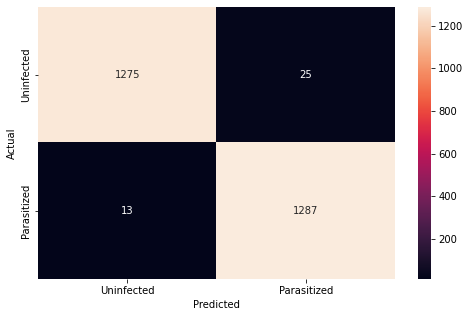

time: 706 ms (started: 2022-04-22 03:51:55 +00:00)


In [55]:
pred = model1.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

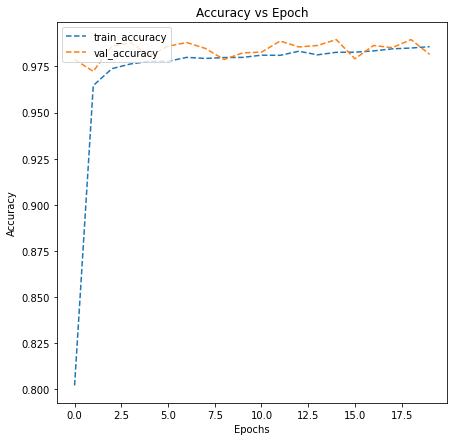

time: 268 ms (started: 2022-04-22 03:51:56 +00:00)


In [56]:
plot_accuracy(history1)

####<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [138]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

time: 16.1 ms (started: 2022-04-22 05:06:09 +00:00)


####<b> Building the Model

In [139]:
model2 = Sequential()
model2.add(Conv2D(64, (3,3), input_shape=(64, 64, 3), padding='same'))
model2.add(LeakyReLU(0.2))
model2.add(Conv2D(32, (3,3), padding='same'))
model2.add(LeakyReLU(0.2))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(16, (3,3), padding='same'))
model2.add(LeakyReLU(0.2))
model2.add(Conv2D(8, (3,3), padding='same'))
model2.add(LeakyReLU(0.2))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(256,activation="relu"))
model2.add(LeakyReLU(0.2))
model2.add(Dense(2,activation='sigmoid'))

adam = optimizers.Adam(learning_rate=0.001)

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                          

####<b>Compiling the model

In [140]:
model2.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

time: 11.4 ms (started: 2022-04-22 05:06:16 +00:00)


In [141]:
model2.save('model2.h5')

time: 44 ms (started: 2022-04-22 05:06:17 +00:00)


<b> Using callbacks

In [142]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

time: 1.36 ms (started: 2022-04-22 05:06:19 +00:00)


<b>Fit and train the model

In [143]:
history2 = model2.fit(train_images,train_labels,batch_size=64,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
312/312 [==============================] - 15s 40ms/step - loss: 0.3222 - accuracy: 0.8505 - val_loss: 0.0106 - val_accuracy: 0.9998
Epoch 2/20
312/312 [==============================] - 10s 34ms/step - loss: 0.0850 - accuracy: 0.9704 - val_loss: 0.0440 - val_accuracy: 0.9876
Epoch 3/20
312/312 [==============================] - 12s 37ms/step - loss: 0.0647 - accuracy: 0.9786 - val_loss: 0.0726 - val_accuracy: 0.9880
Epoch 4/20
312/312 [==============================] - 11s 34ms/step - loss: 0.0524 - accuracy: 0.9814 - val_loss: 0.0829 - val_accuracy: 0.9810
Epoch 5/20
312/312 [==============================] - 9s 28ms/step - loss: 0.0386 - accuracy: 0.9863 - val_loss: 0.0530 - val_accuracy: 0.9902
time: 58.7 s (started: 2022-04-22 05:06:20 +00:00)


<b>Plotting the train and validation accuracy

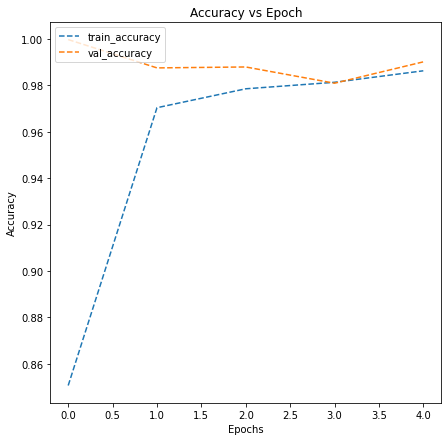

time: 253 ms (started: 2022-04-22 05:07:23 +00:00)


In [144]:
plot_accuracy(history2)

####<b>Evaluating the model

In [145]:
# Evaluate the model to calculate the accuracy
test_acc2 = model2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', test_acc2[1])
train_acc2 = model2.evaluate(train_images, train_labels, verbose=1)
print('\n', 'Train_Accuracy:-', train_acc2[1])

82/82 [==============================] - 1s 8ms/step - loss: 0.0788 - accuracy: 0.9796

 Test_Accuracy:- 0.9796153903007507
780/780 [==============================] - 14s 18ms/step - loss: 0.0575 - accuracy: 0.9816

 Train_Accuracy:- 0.9816491603851318
time: 23.1 s (started: 2022-04-22 05:07:28 +00:00)


#####<b>Observations and insights: 
- Adding Batch Normalization and LeakyRelu as activation function reduced the test accuracy, Recall improves by 45 basis points vs base model and F1 score reduced by 60 basis points
- Training accuracy and Validation accuracy converge at ~98%

<b> Generate the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



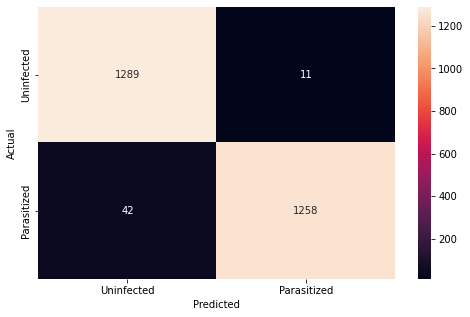

time: 741 ms (started: 2022-04-22 05:08:01 +00:00)


In [146]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model2.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [66]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

time: 14.5 ms (started: 2022-04-22 03:53:48 +00:00)


####<b> Using image data generator

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

time: 322 ms (started: 2022-04-22 03:53:48 +00:00)


In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images

# train_datagen = ImageDataGenerator(horizontal_flip=True 
#                                    ,shear_range = 0.2
#                                    ,zoom_range = 0.2
#                                    ,rotation_range=30
#                                    ,rescale= 1./255)
train_datagen = ImageDataGenerator(horizontal_flip=True 
                                   ,shear_range = 0.2
                                   ,zoom_range = 0.2
                                   ,rotation_range=30
                                   )
#val_datagen  = ImageDataGenerator(rescale = 1./255)
val_datagen  = ImageDataGenerator()

time: 6.5 ms (started: 2022-04-22 03:53:49 +00:00)


In [69]:
#Flowing training images using train_datagen generator
# train_generator = train_datagen.flow_from_directory('cell_images/train'
#                                                     ,target_size = (64,64)
#                                                     ,batch_size=32
#                                                     ,class_mode='categorical') 
train_generator = train_datagen.flow(x = train_images, y = train_labels, batch_size=64, seed=42, shuffle=True) 

time: 2.31 ms (started: 2022-04-22 03:53:49 +00:00)


In [70]:
train_generator

time: 2.95 ms (started: 2022-04-22 03:53:49 +00:00)


In [71]:
# Flowing validation images using val_datagen generator
# val_generator =  val_datagen.flow_from_directory('cell_images/test'
#                                                     ,target_size = (64,64)
#                                                     ,batch_size=32
#                                                     ,class_mode='categorical')
val_generator =  val_datagen.flow(x = test_images, y = test_labels, batch_size=64, seed=42, shuffle=True)

time: 2.81 ms (started: 2022-04-22 03:53:49 +00:00)


####**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

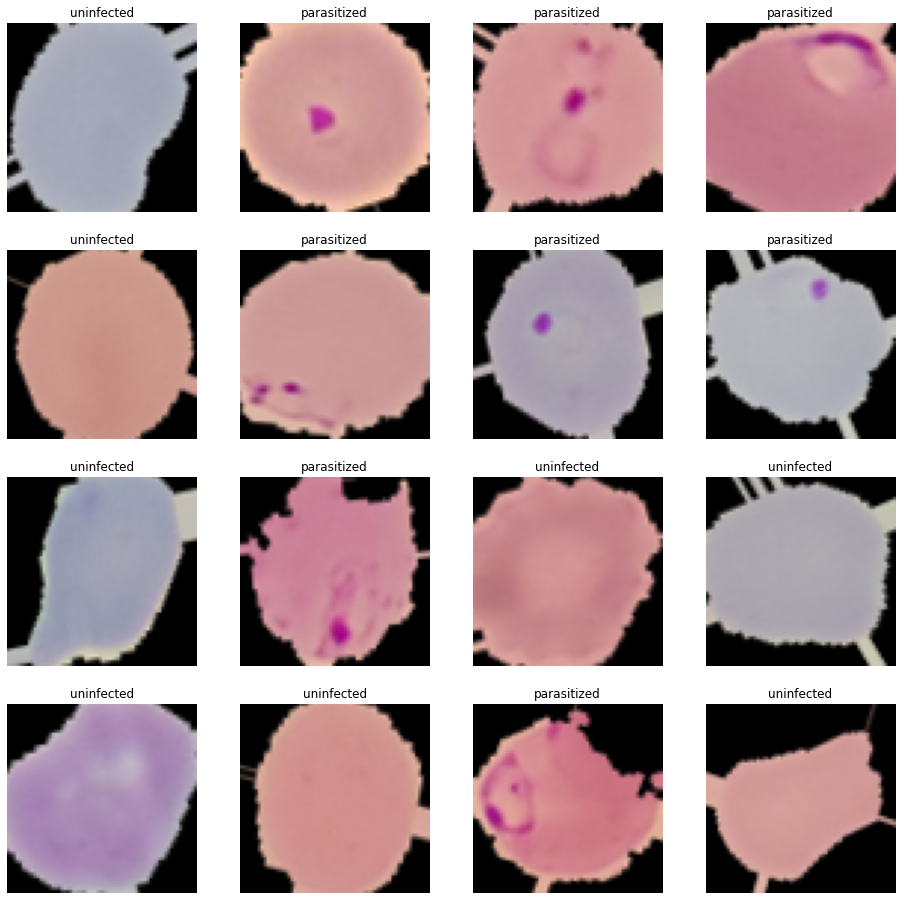

time: 1.14 s (started: 2022-04-22 03:53:49 +00:00)


In [72]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

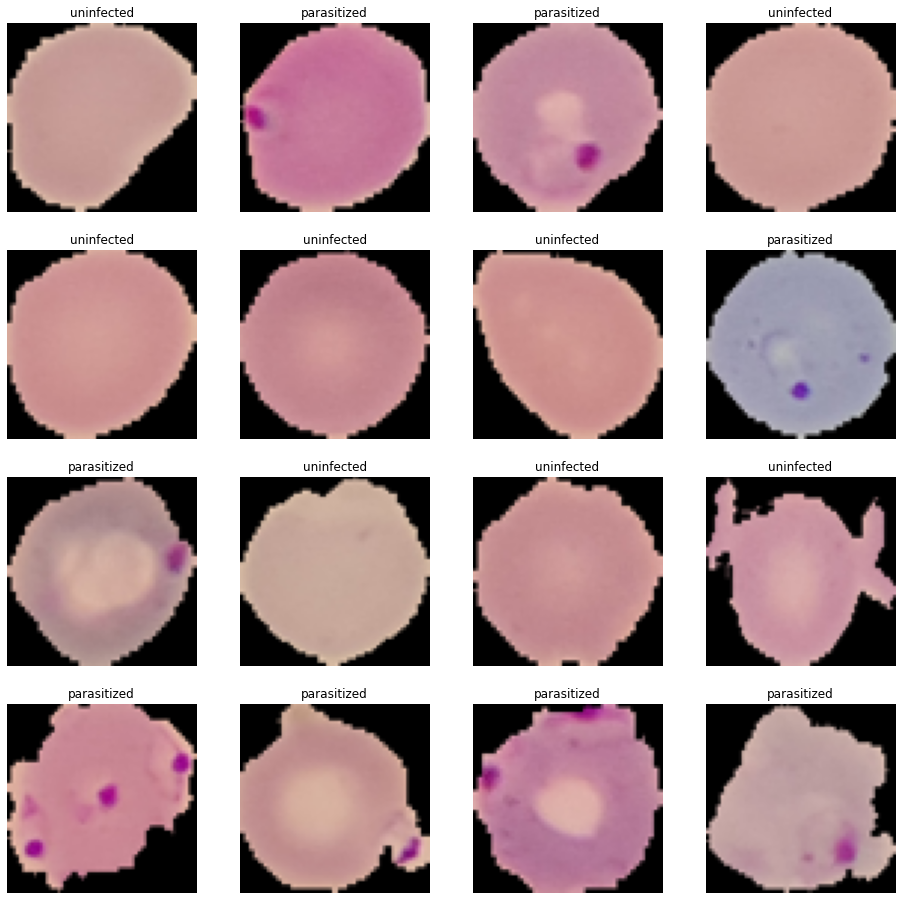

time: 1.38 s (started: 2022-04-22 03:53:50 +00:00)


In [73]:
#Creating an iterable for images and labels from the testing data
images, labels = next(val_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

#####<b>Observations and insights: 

- The following augmentation methods are used on the train_image set
  - horizontal_flip=True
  - shear_range = 0.2
  - zoom_range = 0.2
  - rotation_range=30
- The augmented images have less noise and provide more information for the model building 
- These images will need to be converted to Grayscale and passed through a custom contrast filter to increase the focus on the parasitized area
- A mask R-CNN model could further help in detection of the affected areas in the cells

####<b>Building the Model

In [74]:
model3 = Sequential()

model3.add(Conv2D(64, (3,3), input_shape=(64, 64, 3), padding='same'))
model3.add(LeakyReLU(0.2))

model3.add(Conv2D(32, (3,3), padding='same'))
model3.add(LeakyReLU(0.2))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(16, (3,3), padding='same'))
model3.add(LeakyReLU(0.2))

model3.add(Conv2D(8, (3,3), padding='same'))
model3.add(LeakyReLU(0.2))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Flatten())

model3.add(Dense(256,activation="relu"))
model3.add(LeakyReLU(0.2))

model3.add(Dense(2,activation='sigmoid'))

adam = optimizers.Adam(learning_rate=0.001)

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                          

In [75]:
model3.compile(loss='binary_crossentropy', optimizer=adam, metrics = ['accuracy'])

time: 12.4 ms (started: 2022-04-22 03:53:52 +00:00)


In [76]:
model3.save('model3.h5')

time: 68.3 ms (started: 2022-04-22 03:53:52 +00:00)


<b>Using Callbacks

In [77]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

time: 1.92 ms (started: 2022-04-22 03:53:52 +00:00)


<b> Fit and Train the model

In [78]:
history3 = model3.fit(train_generator,validation_data=val_generator,batch_size=32,callbacks=callbacks,epochs=20,verbose=1)

Epoch 1/20
390/390 [==============================] - 59s 133ms/step - loss: 0.3107 - accuracy: 0.8620 - val_loss: 0.1816 - val_accuracy: 0.9269
Epoch 2/20
390/390 [==============================] - 52s 133ms/step - loss: 0.0990 - accuracy: 0.9685 - val_loss: 0.3331 - val_accuracy: 0.8854
Epoch 3/20
390/390 [==============================] - 53s 137ms/step - loss: 0.0892 - accuracy: 0.9724 - val_loss: 0.0914 - val_accuracy: 0.9823
Epoch 4/20
390/390 [==============================] - 54s 139ms/step - loss: 0.0801 - accuracy: 0.9740 - val_loss: 0.0614 - val_accuracy: 0.9800
Epoch 5/20
390/390 [==============================] - 55s 141ms/step - loss: 0.0775 - accuracy: 0.9745 - val_loss: 0.0721 - val_accuracy: 0.9812
Epoch 6/20
390/390 [==============================] - 52s 133ms/step - loss: 0.0743 - accuracy: 0.9759 - val_loss: 0.0556 - val_accuracy: 0.9858
Epoch 7/20
390/390 [==============================] - 54s 139ms/step - loss: 0.0719 - accuracy: 0.9764 - val_loss: 0.0650 - val_ac

####<B>Evaluating the model

<b>Plot the train and validation accuracy

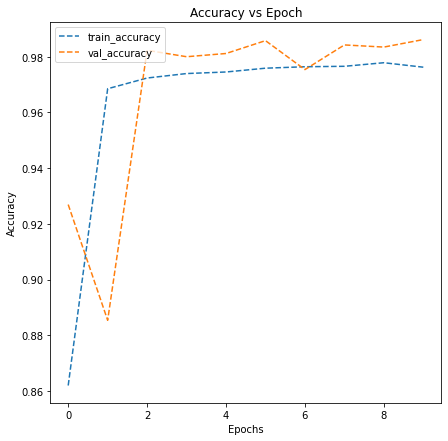

time: 362 ms (started: 2022-04-22 04:02:46 +00:00)


In [79]:
# plotting the accuracies
plot_accuracy(history3)

In [80]:
# Evaluating the model on test data
test_acc3 = model3.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', test_acc3[1])
train_acc3 = model.evaluate(train_images, train_labels, verbose=1)
print('\n', 'Train_Accuracy:-', train_acc3[1])

82/82 [==============================] - 3s 38ms/step - loss: 0.0480 - accuracy: 0.9862

 Test_Accuracy:- 0.9861538410186768
780/780 [==============================] - 9s 12ms/step - loss: 0.0498 - accuracy: 0.9859

 Train_Accuracy:- 0.9859363436698914
time: 13 s (started: 2022-04-22 04:02:47 +00:00)


<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



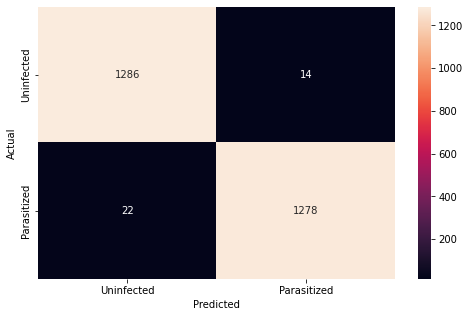

time: 601 ms (started: 2022-04-22 04:03:00 +00:00)


In [81]:
pred = model3.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG19)**

## Understanding the VGG-19 model
The VGG-19 model is a 19-layer (convolution and fully connected) deep learning network built on the ImageNet database, which was developed for the purpose of image recognition and classification. This model was built by Karen Simonyan and Andrew Zisserman and is described in their paper "Very deep convolutional networks for large-scale image recognition." The architecture of the VGG-19 model is:
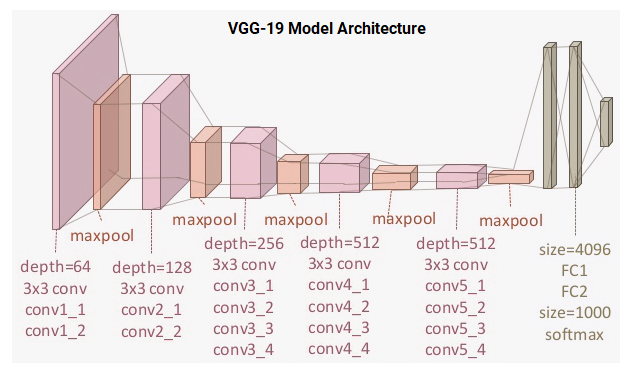

You can see that we have a total of **16 convolution layers** using **3x3 convolution filters** along with **max pooling layers** for **downsampling** and **two fully connected hidden layers** of 4,096 units in each layer followed by a **dense layer** of 1,000 units, where each unit represents one of the image categories in the ImageNet database. We do not need the last three layers since we will be using our own fully connected dense layers to predict malaria. We are more concerned with the first five blocks so we can leverage the VGG model as an effective feature extractor.

We will use one of the models as a simple **feature extractor** by freezing the five convolution blocks to make sure their weights aren't updated after each epoch. For the last model, we will apply fine-tuning to the VGG model, where we will unfreeze the last two blocks (Block 4 and Block 5) so that their weights will be updated in each epoch (per batch of data) as we train our own model.

In [82]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

time: 15.8 ms (started: 2022-04-22 04:03:00 +00:00)


In [83]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Model

vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg19.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [84]:
for layer in vgg19.layers: #do not train all the layers
    layer.trainable = False

time: 3.09 ms (started: 2022-04-22 04:03:05 +00:00)


In [85]:
folders = glob('cell_images/train/*')

time: 1.65 ms (started: 2022-04-22 04:03:05 +00:00)


In [86]:
folders

['cell_images/train/parasitized', 'cell_images/train/uninfected']

time: 4.95 ms (started: 2022-04-22 04:03:05 +00:00)


In [87]:
x = Flatten()(vgg19.output)

time: 5.62 ms (started: 2022-04-22 04:03:05 +00:00)


In [88]:
#x = Dense(256,activation = 'relu')(x)

time: 705 µs (started: 2022-04-22 04:03:05 +00:00)


In [89]:
#x = Dropout(0.3)(x)

time: 629 µs (started: 2022-04-22 04:03:05 +00:00)


In [90]:
#x = BatchNormalization()(x)

time: 652 µs (started: 2022-04-22 04:03:05 +00:00)


In [91]:
pred = Dense(len(folders),activation = 'softmax')(x)

time: 23.3 ms (started: 2022-04-22 04:03:05 +00:00)


In [92]:
model4 = Model(inputs=vgg19.input,outputs=pred)

time: 6.27 ms (started: 2022-04-22 04:03:05 +00:00)


In [93]:
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [94]:
model4=Sequential()

model4.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model4.add(MaxPooling2D(pool_size=2))

model4.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model4.add(MaxPooling2D(pool_size=2))

model4.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model4.add(MaxPooling2D(pool_size=2))

model4.add(Flatten())

model4.add(Dense(500,activation='relu'))
# model4.add(Dropout(0.3))
# model4.add(BatchNormalization())

model4.add(Dense(2,activation='softmax'))
model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

####<b>Compiling the model

In [95]:
# Compiling the model 
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

time: 10.1 ms (started: 2022-04-22 04:03:05 +00:00)


In [96]:
model4.save('model4.h5')

time: 36.3 ms (started: 2022-04-22 04:03:05 +00:00)


<b> using callbacks

In [97]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

time: 1.16 ms (started: 2022-04-22 04:03:05 +00:00)


<b>Fit and Train the model

In [98]:
#Fitting the model and running the model for 10 epochs
history4 = model4.fit(train_images,train_labels,batch_size=128,callbacks=callbacks,validation_split=0.2,epochs=50,verbose=1)

Epoch 1/50
156/156 [==============================] - 16s 40ms/step - loss: 0.6182 - accuracy: 0.6690 - val_loss: 1.0586 - val_accuracy: 0.2486
Epoch 2/50
156/156 [==============================] - 5s 30ms/step - loss: 0.3982 - accuracy: 0.8275 - val_loss: 0.2363 - val_accuracy: 0.9411
Epoch 3/50
156/156 [==============================] - 4s 23ms/step - loss: 0.1774 - accuracy: 0.9351 - val_loss: 0.1163 - val_accuracy: 0.9665
Epoch 4/50
156/156 [==============================] - 3s 21ms/step - loss: 0.1234 - accuracy: 0.9554 - val_loss: 0.1498 - val_accuracy: 0.9527
Epoch 5/50
156/156 [==============================] - 4s 26ms/step - loss: 0.1128 - accuracy: 0.9591 - val_loss: 0.0620 - val_accuracy: 0.9942
Epoch 6/50
156/156 [==============================] - 4s 25ms/step - loss: 0.0898 - accuracy: 0.9673 - val_loss: 0.2689 - val_accuracy: 0.9042
Epoch 7/50
156/156 [==============================] - 4s 27ms/step - loss: 0.0800 - accuracy: 0.9709 - val_loss: 0.1228 - val_accuracy: 0.963

<b>Plot the train and validation accuracy

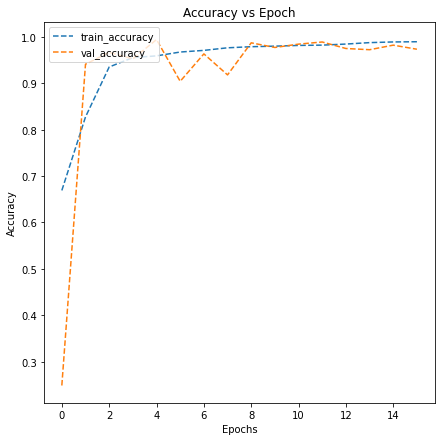

time: 240 ms (started: 2022-04-22 04:04:23 +00:00)


In [99]:
# plotting the accuracies
plot_accuracy(history4)

##### Observations and insights: 
- The validation and the train curves are trending close to each other which means the model is robust and there is no evidence of overfitting

####<b> Evaluating the model

In [100]:
# Evaluating the model on test data
test_acc4 = model4.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', test_acc4[1])
train_acc4 = model4.evaluate(train_images, train_labels, verbose=1)
print('\n', 'Train_Accuracy:-', train_acc4[1])

82/82 [==============================] - 3s 34ms/step - loss: 0.0744 - accuracy: 0.9785

 Test_Accuracy:- 0.9784615635871887
780/780 [==============================] - 9s 12ms/step - loss: 0.0364 - accuracy: 0.9901

 Train_Accuracy:- 0.9901033639907837
time: 13.7 s (started: 2022-04-22 04:04:23 +00:00)


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



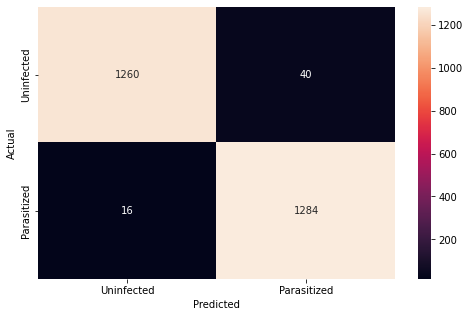

time: 672 ms (started: 2022-04-22 04:04:37 +00:00)


In [101]:
# Plot the confusion matrix and generate a classification report for the model
pred = model4.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [102]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

time: 1.88 ms (started: 2022-04-22 04:04:38 +00:00)


In [103]:
model5=model4

time: 945 µs (started: 2022-04-22 04:04:38 +00:00)


In [104]:
history5 = model5.fit_generator(train_generator,epochs = 30,validation_data=val_generator,validation_steps=len(val_generator))

Epoch 1/30
390/390 [==============================] - 55s 140ms/step - loss: 0.0972 - accuracy: 0.9680 - val_loss: 0.0704 - val_accuracy: 0.9769
Epoch 2/30
390/390 [==============================] - 58s 149ms/step - loss: 0.0793 - accuracy: 0.9728 - val_loss: 0.1033 - val_accuracy: 0.9623
Epoch 3/30
390/390 [==============================] - 58s 149ms/step - loss: 0.0743 - accuracy: 0.9740 - val_loss: 0.0521 - val_accuracy: 0.9865
Epoch 4/30
390/390 [==============================] - 55s 142ms/step - loss: 0.0700 - accuracy: 0.9766 - val_loss: 0.0467 - val_accuracy: 0.9869
Epoch 5/30
390/390 [==============================] - 56s 143ms/step - loss: 0.0708 - accuracy: 0.9757 - val_loss: 0.0555 - val_accuracy: 0.9838
Epoch 6/30
390/390 [==============================] - 57s 147ms/step - loss: 0.0671 - accuracy: 0.9774 - val_loss: 0.0460 - val_accuracy: 0.9862
Epoch 7/30
390/390 [==============================] - 57s 147ms/step - loss: 0.0660 - accuracy: 0.9778 - val_loss: 0.0476 - val_ac

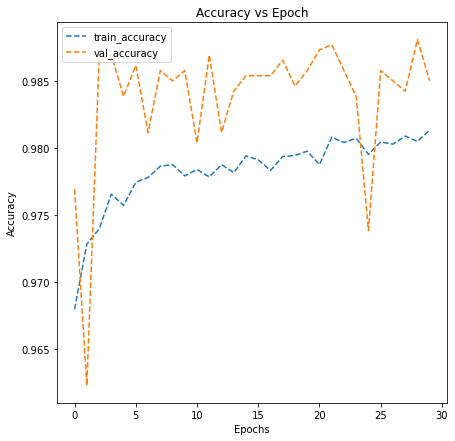

time: 406 ms (started: 2022-04-22 04:32:25 +00:00)


In [105]:
# plotting the accuracies
plot_accuracy(history5)

In [106]:
# Evaluating the model on test data
test_acc5 = model5.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', test_acc5[1])
train_acc5 = model5.evaluate(train_images, train_labels, verbose=1)
print('\n', 'Train_Accuracy:-', train_acc5[1])

82/82 [==============================] - 1s 12ms/step - loss: 0.0385 - accuracy: 0.9850

 Test_Accuracy:- 0.9850000143051147
780/780 [==============================] - 9s 12ms/step - loss: 0.0404 - accuracy: 0.9846

 Train_Accuracy:- 0.9845740795135498
time: 12.1 s (started: 2022-04-22 04:32:26 +00:00)


In [107]:
model5.save('model5.h5')

time: 76.5 ms (started: 2022-04-22 04:32:38 +00:00)


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.99      0.98      0.98      2600
weighted avg       0.99      0.98      0.98      2600



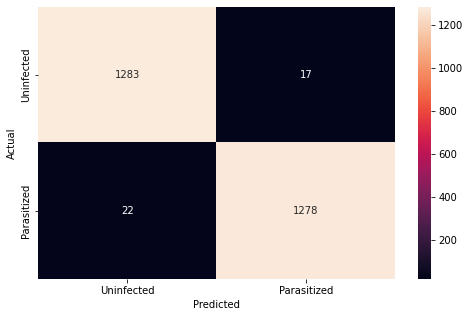

time: 490 ms (started: 2022-04-22 04:32:38 +00:00)


In [108]:
# Plot the confusion matrix and generate a classification report for the model
pred = model4.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choosw the model with the best accuracy scores from all the above models and save it as a final model.


###<b> Observations and Conclusions drawn from the final model: _____



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

### **Insights**

####**Refined insights**:
- The **Base Model network is the most parsimonious** and gives robust results (***98.59% accuracy and 98.69% recall**)
- As we **increase the model in complexity** by adding more layers, testing LeakyRelu as the activation function, adding BatchNormalization and Image Augmentation, the **incremental performance of the models does not justify** the computational cost (Max Recall is 99.13% and accuracy does not improve significantly)
- **Transfer Learning simplifies complex problem** statements, but the **computation cost is high**
- **Image Augmentation is a very powerful tool** when **data set is limited**. It **did not provide a significant lift** in model performance in this scenario and model **computation time went up 14x**
- In order to **make this technology available in remote locations and at low cost, a phone app would provide the best channel** and keeping the model simple and robust could significantly reduce the risk of false negatives
- Tensorflow Lite and Tensorflow Serving can be used to deploy this on a mobile app or web-based app

####**Comparison of various techniques and their relative performance**:
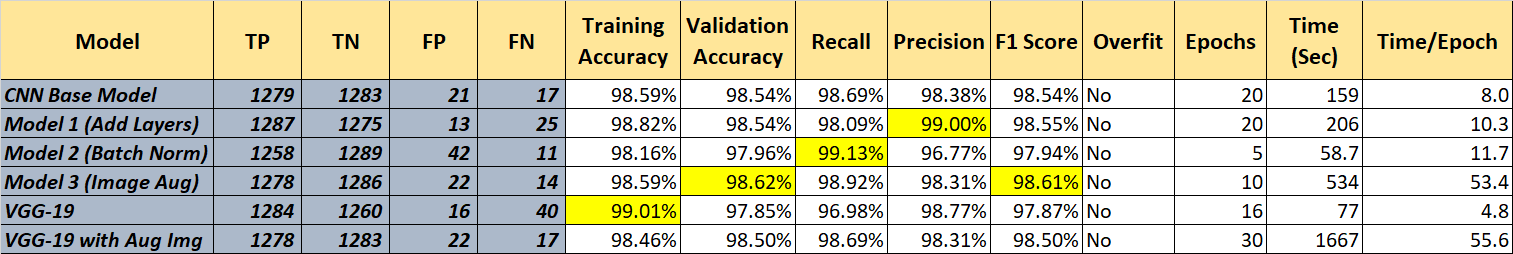

Base Model with Batch Normalization has the best Recall (99.13%) and the CNN model with augmented images has the best F1 Score (98.61%). The train accuracy is for this model is also highest. Low recall being so critical here since we want to minimize false negatives to facilitate early diagosis and treatment, the **Batch Normalization model is recommended**.

####**Proposal for the final solution design**:

The above models demonstrate very close prformance and every run changes the relative performance of a specific model. My recommedation here is to use an ensemble model for prediction on the web-based on mobile app. This will further generalize the model performance and ensure higher degree of accuracy from the predictions.
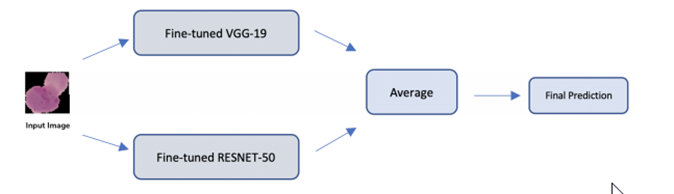


Considering that over 90% of the cases are in the African region and economically backward areas of the world, a mobile-based technology can ensure cost efficiency and wide reach. Microscopy takes upto 50 mins to diagnose one case and there is high degree of uncertainty given available level of skills of lab techs and sugjectivity. This can be reduced to just under 1s/image using a Tensorflow Lite model deployed on a mobile-based app in an offline setup.

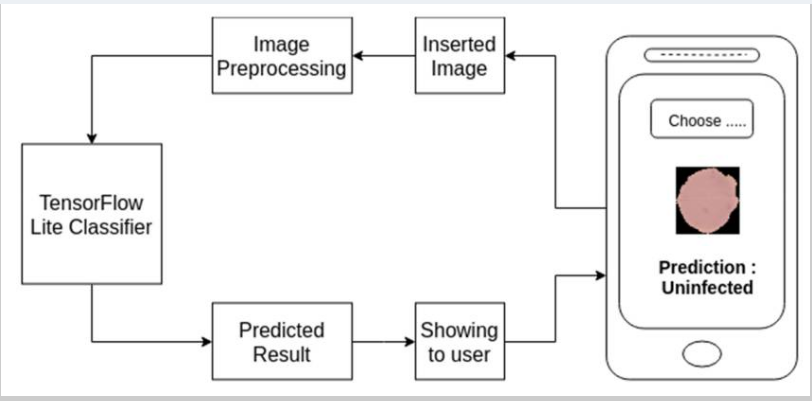


For a web -based application Flask or Tensorflow Serving can be used. The following diagram shows the architecture of a Servable.(source: https://www.analyticsvidhya.com/blog/2020/03/tensorflow-serving-deploy-deep-learning-models/)
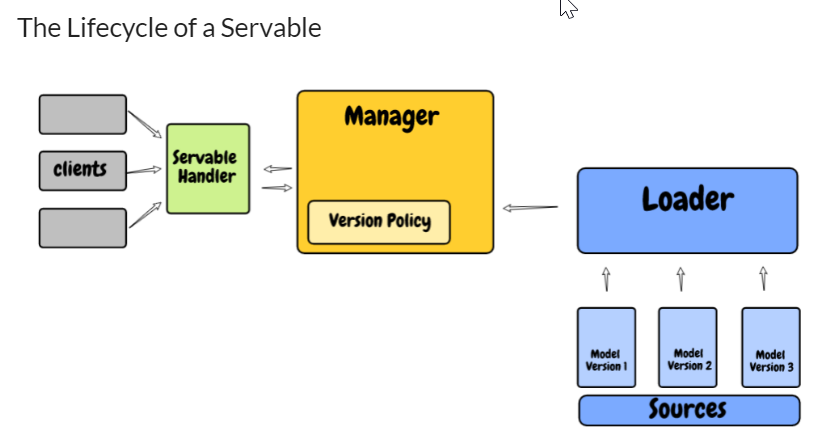